# Following Tensorflow segmentation tutorial
[Tutorial](https://www.tensorflow.org/tutorials/images/segmentation)

In [448]:
from duts import DutsDataset

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2

In [174]:
%load_ext blackcellmagic

The blackcellmagic extension is already loaded. To reload it, use:
  %reload_ext blackcellmagic


In [175]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


First, **import the DUTS data**.

In [511]:
ds=DutsDataset("../DUTS")
print(len(ds.training_images), len(ds.test_images))

10553 5019


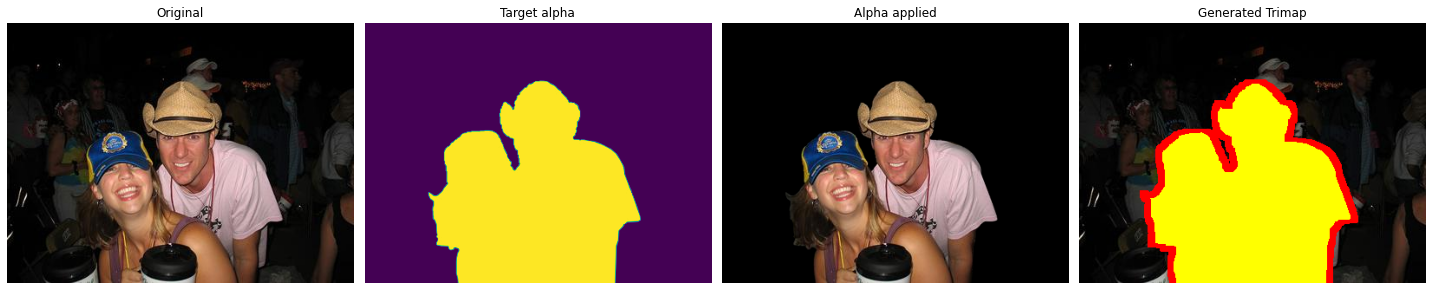

In [512]:
img=ds.training_images[np.random.randint(0,len(ds.training_images))]
img.show_all()
plt.show()

## Image segmentation 

The goal is to use the _pix2pix_ U-net model to generate the trimap directly.

In [178]:
!pip install -q git+https://github.com/tensorflow/examples.git

  DEPRECATION: tensorflow-examples was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. You can find discussion regarding this at https://github.com/pypa/pip/issues/8368.


In [236]:
from tensorflow_examples.models.pix2pix import pix2pix

### The input

Create a helper function that converts an image and mask to the required format.

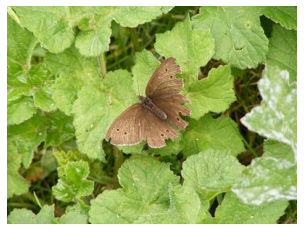

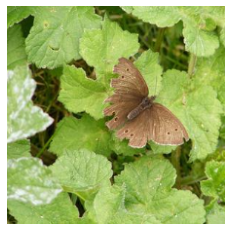

In [449]:
def prepare_img(img, target_size=(224, 224)):
    # normalize
    image = img.get_image() / 255.0
    height, width = image.shape[:2]
    trimap = np.atleast_3d(img.generate_trimap())
    # remap trimap to {0,1,2} to fit classifciation model
    trimap=np.round((trimap * 2)).astype(int)

    # convert to tensor
    image = tf.convert_to_tensor(image)
    trimap = tf.convert_to_tensor(trimap, dtype=tf.uint8)
    

    # random crop to target size
    crop_scale =np.array(target_size)/min(width, height)
    crop_height, crop_width = (np.array(target_size) / crop_scale).astype(int)

    
    x0 = np.random.randint(0, width - crop_width) if crop_width<width else 0
    y0 = np.random.randint(0, height - crop_height) if crop_height<height else 0

    image = tf.image.crop_to_bounding_box(image, y0, x0, crop_height, crop_width)
    trimap = tf.image.crop_to_bounding_box(trimap, y0, x0, crop_height, crop_width)

    # rescale, should 
    image = tf.image.resize(image, target_size)
    trimap = tf.image.resize(trimap, target_size, method="nearest")

    # randomly flip to bring in some variation
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        trimap = tf.image.flip_left_right(trimap)

    return image, trimap

ds.training_images[2].show_image()
test_image, test_mask=prepare_img(ds.training_images[2])
plt.figure()
plt.imshow(test_image)
plt.axis("off")
plt.show()

Redefine everything in TensorFlow functions, to be able to correctly train on the full dataset.

In [513]:
def generate_trimap(mask_in: np.ndarray):
    mask_in = mask_in[:, :, 0]
    kernel_size = np.array(mask_in.shape) // 40
    kernel = np.ones(kernel_size, np.uint8)

    dilation = cv2.dilate(mask_in, kernel, iterations=1)
    erosion = cv2.erode(mask_in, kernel, iterations=1)

    return np.atleast_3d(np.round(erosion + dilation))

In [514]:
def random_crop(image_dims, target_size):
#     height, width = image.shape[:2]
    height,width=image_dims[:2]
    crop_scale = np.array(target_size) / np.min([width, height])
    crop_height, crop_width = (np.array(target_size) / crop_scale).astype(int)

    x0 = np.random.randint(0, width - crop_width) if crop_width < width else 0
    y0 = np.random.randint(0, height - crop_height) if crop_height < height else 0
    
    return y0, x0, crop_height, crop_width

In [515]:
@tf.function
def random_crop_both(image, mask, target_size):
    dims=tf.shape(image)
    
    y0, x0, crop_height, crop_width = tf.py_function(random_crop, (dims, target_size), [tf.int32, tf.int32, tf.int32, tf.int32])
    
    image=tf.image.crop_to_bounding_box(image, y0, x0, crop_height, crop_width)
    mask=tf.image.crop_to_bounding_box(mask, y0, x0, crop_height, crop_width)
    
    return image, mask

In [516]:
@tf.function
def prepare_img_tf(image_path, mask_path, target_size=(224, 224)):
    # load images
    image = (
        tf.cast(tf.image.decode_jpeg(tf.io.read_file(image_path)), tf.float32) / 255.0
    )
    mask = (
        tf.cast(tf.image.decode_png(tf.io.read_file(mask_path), channels=1), tf.float32)
        / 255.0
    )

    # generate trimap from ground truth
    trimap = tf.numpy_function(generate_trimap, [mask], tf.float32)
    trimap.set_shape(
        mask.shape
    )  # very important line! cost me almost full day of debugging despair

    # crop images randomly to fit largest square
    image, trimap = random_crop_both(image, trimap, target_size)

    # randomly flip to bring in some variation
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        trimap = tf.image.flip_left_right(trimap)

    # rescale both to target size
    image = tf.image.resize(image, target_size)
    trimap = tf.image.resize(trimap, target_size, method="nearest")

    return image, tf.cast(trimap, tf.uint8)

In [520]:
train=ds.get_tf_training_set(100)
train=train.map(prepare_img_tf)

In [521]:
test=ds.get_tf_test_set(100)
test=test.map(prepare_img_tf)

In [ ]:
subset = ds.training_images[:100]
images, targets=zip(*map(prepare_img, subset))
train=tf.data.Dataset.from_tensor_slices((list(images), list(targets)))

In [ ]:
tsubset = ds.test_images[:100]
timages, ttargets=zip(*map(prepare_img, tsubset))
test=tf.data.Dataset.from_tensor_slices((list(timages), list(ttargets)))

Inspect if it is still loaded ok.

tf.Tensor(400, shape=(), dtype=int32) tf.Tensor(302, shape=(), dtype=int32)
tf.Tensor(400, shape=(), dtype=int32) tf.Tensor(300, shape=(), dtype=int32)


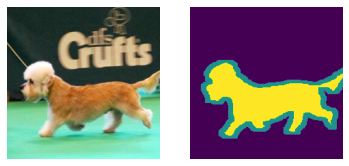

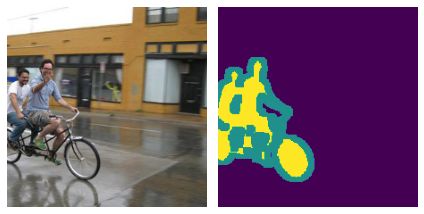

In [493]:
for x,y in train.take(2):
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(x)
    plt.axis("off")
    plt.subplot(1,2,2)
    plt.imshow(y)
    plt.axis("off")

plt.tight_layout()
plt.show()

Some options for the dataset.

In [522]:
TRAIN_LENGTH = len(train)
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
OUTPUT_CHANNELS=3

In [495]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

## Model definition

Download pre-trained model, _MobileNetV2_.

In [496]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[224, 224, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

In [497]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]


Define the model.

In [498]:
def unet_model(output_channels):
    inputs = tf.keras.layers.Input(shape=[224, 224, 3])

    # Downsampling through the model
    skips = down_stack(inputs)
    x = skips[-1]
    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

    # This is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(
        output_channels, 3, strides=2,
        padding='same')  #64x64 -> 128x128

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

### Training the model

In [499]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Define some display functions.

tf.Tensor(400, shape=(), dtype=int32) tf.Tensor(302, shape=(), dtype=int32)


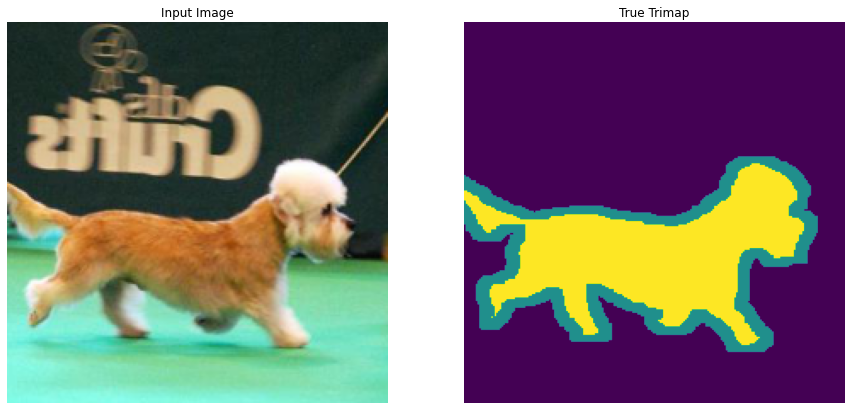

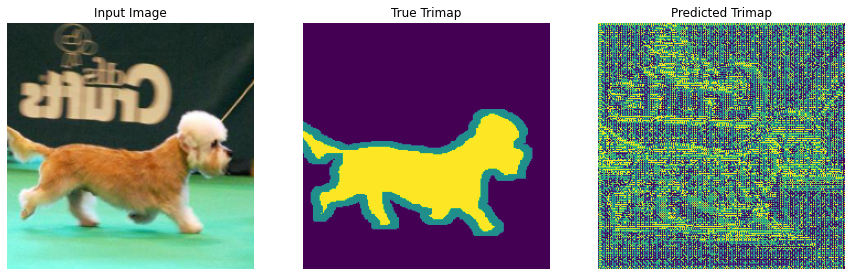

In [500]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ["Input Image", "True Trimap", "Predicted Trimap"]

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i + 1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis("off")
    plt.show()
    

def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]


def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display(
            [
                sample_image,
                sample_mask,
                create_mask(model.predict(sample_image[tf.newaxis, ...])),
            ]
        )
show_predictions()


The training itself.

In [501]:
from IPython.display import clear_output


class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print("\nSample Prediction after epoch {}\n".format(epoch + 1))

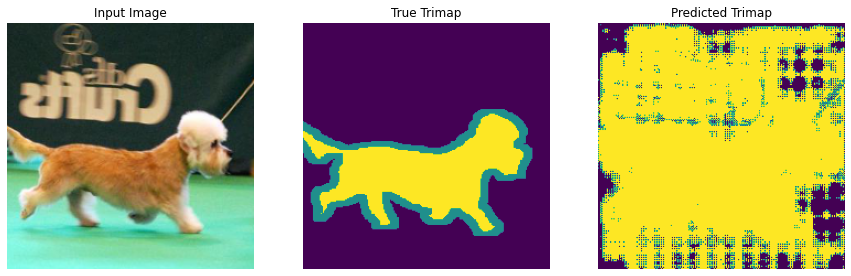


Sample Prediction after epoch 20



In [502]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = len(test) // BATCH_SIZE // VAL_SUBSPLITS

model_history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_steps=VALIDATION_STEPS,
    validation_data=test_dataset,
    callbacks=[DisplayCallback()],
)

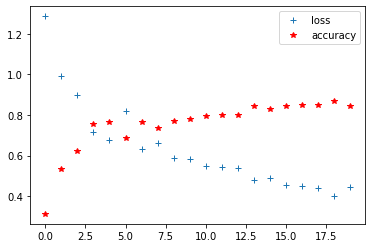

In [504]:
model_history.history
plt.plot(model_history.history["loss"], "+",label="loss")
plt.plot(model_history.history["accuracy"], "r*", label="accuracy")
plt.legend()
plt.show()

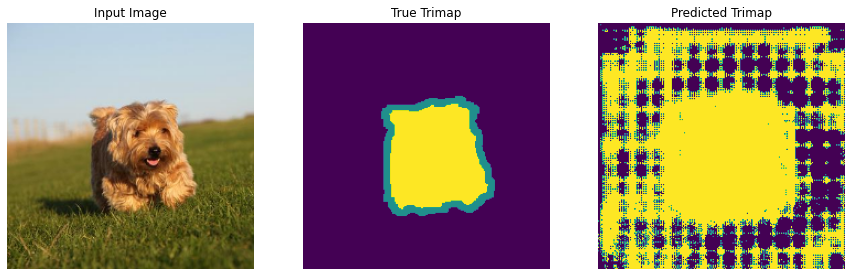

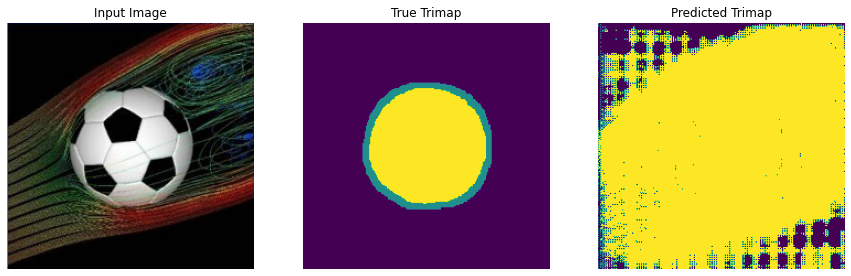

In [505]:
show_predictions(test_dataset, 2)